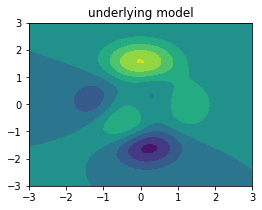

In [11]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np

from sumomo import api
from utils import peaks, plot_peaks, plot_gp, func_1d


plot_peaks()

In [12]:
api.initialise(100, [(-3.0, 3.0), (-3.0, 3.0)], 1, 'lhs')
for i in range(api.x.shape[0]):
    api.y[i] = peaks(api.x[i])

api.split()
api.scale()

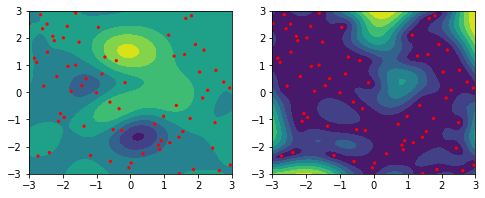

In [13]:
api.init_regressor('gp', noise=0.0)
with np.errstate(divide='ignore'):
    api.regressor.fit(api.x_train_, api.y_train_)

plot_gp(api, show_samples=True)

In [14]:
api.test('rmse')

0.40200821796994507

In [15]:
print(api.regressor.length_scale)

0.4409555278061616


In [16]:
from sklearn.datasets import make_moons
from sumomo.gp import GPC


X_train, t = make_moons(50, noise=0.3)
t = t.reshape(-1, 1)

gpc = GPC()
gpc.fit(X_train, t)
print(gpc.l, gpc.kappa)

0.6425211754681396 34.64661322326672


[[0.49999979]
 [0.49999961]
 [0.49999931]
 ...
 [0.49994392]
 [0.49998164]
 [0.50000065]]
[[0.49999979]
 [0.49999961]
 [0.49999931]
 ...
 [0.49994392]
 [0.49998164]
 [0.50000065]]


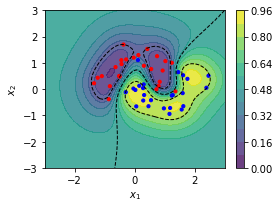

In [17]:
x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
X = np.c_[x1grid.ravel(), x2grid.ravel()]

prediction, std = gpc.predict(X, return_std=True)
print(prediction)
formulation_pred = np.zeros_like(prediction)
for i in range(len(formulation_pred)):
    formulation_pred[i] = gpc.formulation(X[i])
print(formulation_pred)
prediction = prediction.reshape(x1grid.shape)
std = std.reshape(x1grid.shape)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)
c1 = ax1.contourf(x1, x2, prediction, levels=12, alpha=0.8)
ax1.scatter(X_train[:, 0], X_train[:, 1], s=10, c=t, cmap='bwr_r')
ax1.contour(x1, x2, prediction, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
fig.colorbar(c1, ax=ax1)
plt.tight_layout()

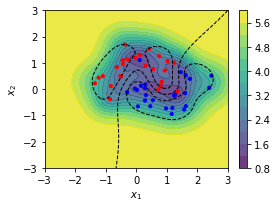

In [18]:
fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)
c1 = ax1.contourf(x1, x2, std, levels=12, alpha=0.8)
ax1.scatter(X_train[:, 0], X_train[:, 1], s=10, c=t, cmap='bwr_r')
ax1.contour(x1, x2, prediction, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
fig.colorbar(c1, ax=ax1)
plt.tight_layout()

In [19]:
space = [(-6.0, 6.0)]
n_samples = 11

from sumomo.gp import GPR

x_train = api.initialise(n_samples, space)

y_train = func_1d(x_train)

t = np.ones_like(x_train)
t[x_train < -4] = 0
t[x_train > 2] = 0
t = t.reshape(-1, 1)

gpr = GPR()
gpr.fit(x_train[t.ravel()==1, :], y_train[t.ravel()==1])

gpc = GPC()
gpc.fit(x_train, t)

/Users/alexdurkin/miniconda3/envs/phd-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


In [20]:
x_new = np.arange(-8, 8, 0.01).reshape(-1, 1)
pred, std = gpr.predict(x_new, return_std=True)
un = 1.96 * std
f, s = gpc.predict(x_new, return_std=True)

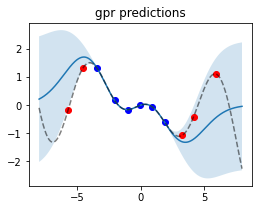

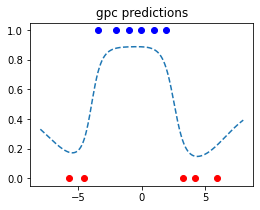

In [21]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, pred)

ax.plot(x_new, func_1d(x_new), ls='--', alpha=0.5, c='k')
ax.title.set_text('gpr predictions')
ax.fill_between(x_new.ravel(), pred.ravel() + un.ravel(), pred.ravel() - un.ravel(), alpha=0.2)
ax.scatter(x_train[t.ravel()==1, :], y_train[t.ravel()==1], c='b')
ax.scatter(x_train[t.ravel()==0, :], y_train[t.ravel()==0], c='r')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, f, ls='--')
ax.scatter(x_train[t==1], t[t==1], c='b')
ax.scatter(x_train[t==0], t[t==0], c='r')
ax.title.set_text('gpc predictions')
plt.show()

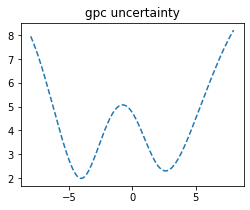

In [22]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, s, ls='--')
ax.title.set_text('gpc uncertainty')
plt.show()